In [ ]:
import pymongo as pm
import ssl, certifi
from datetime import datetime, timedelta, timezone
import numpy as np
import matplotlib.pyplot as plt

In [2]:
USER = "ictts"
PWD  = "Ict4SM22!"
HOST = "bigdatadb.polito.it"
PORT = 27017
DB   = "carsharing"

client = pm.MongoClient(HOST,
ssl=True, #there might be conflicts, try to set to False
authSource = DB,
username = USER,
password =PWD,
port=PORT,
tlsAllowInvalidCertificates=True)

db = client[DB]
db.list_collection_names()

['enjoy_DebugInfo',
 'ictts_PermanentBookings',
 'ictts_enjoy_PermanentBookings',
 'enjoy_PermanentBookings',
 'BigDive7_PermanentBookings',
 'enjoy_ActiveParkings',
 'test_collection',
 'DebugInfo',
 'PermanentBookings',
 'PermanentParkings',
 'system.js',
 'ActiveParkings',
 'enjoy_PermanentParkings',
 'hexs_gen',
 'enjoy_ActiveBookings',
 'ActiveBookings']

**PART 1:**  
**Check if the booking records requires to be filtered to get valid rentals**

In [3]:
collections = ["ictts_PermanentBookings", "ictts_enjoy_PermanentBookings"]
city = "Torino"

In [8]:
# query to get the booking records in Turin and evaluate its duration by subtracting the start time from the end time
pipeline = [
    {
        "$match": {
            "city": city
        }
    },
    {
        "$project": {
            "init_loc": 1,
            "final_loc": 1,
            "duration": {
                "$subtract": ["$final_time", "$init_time"]
            }
        }
    }
]

car2go_booking_durations = list(db["ictts_PermanentBookings"].aggregate(pipeline))
enjoy_booking_durations = list(db["ictts_enjoy_PermanentBookings"].aggregate(pipeline))

booking_records = car2go_booking_durations + enjoy_booking_durations

# filter out records outside the 2 minutes and 1 hour range
booking_records = [record for record in booking_records if 120 <= record["duration"] <= 3600]

# print booking records structure
print(booking_records[0])

{'_id': ObjectId('5a3bb3af20c3dd47cf59003d'), 'final_loc': {'coordinates': [7.68634, 45.07567], 'type': 'Point'}, 'init_loc': {'coordinates': [7.68486, 45.08276], 'type': 'Point'}, 'duration': 1215}


/tmp/ipykernel_58/1970140351.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


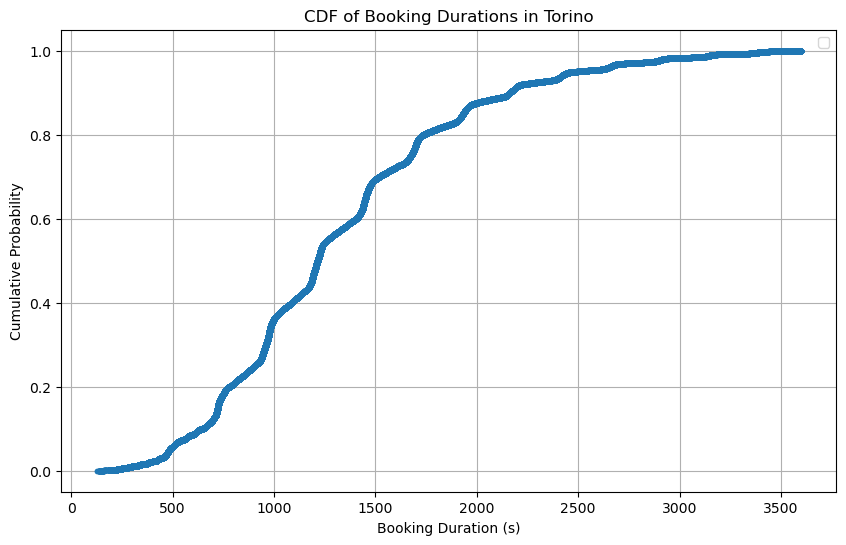

In [9]:
# plot the CDF of the booking durations
plt.figure(figsize=(10,6))
plt.plot(np.sort([record['duration'] for record in booking_records]), np.linspace(0, 1, len(booking_records)), marker='.', linestyle='none')
plt.xlabel('Booking Duration (s)')
plt.ylabel('Cumulative Probability')
# plt.axvline(x=3600, color='r', linestyle='--', label='1 hour')
# plt.axvline(x=120, color='g', linestyle='--', label='2 minutes')
plt.title(f'CDF of Booking Durations in {city}')
plt.grid()
plt.legend()
plt.show()

The CDF of the durations of all the bookings in Torino shows no need to filter the records, since almost all the bookings have a duration in the outlier range used in the first lab [2 - 60 minutes].

**Derive the OD matrix based on the zones of Torino**  

Compares:  
- Weekdays (Monday to Friday) in day time (8am - 8pm) and Weekends (Saturday and Sunday) in day time (8am - 8pm)
- Car2go weekdays in day time vs Enjoy weekdays in day time

In [11]:
!pip install geojson
!pip install shapely

import geojson
from shapely.geometry import shape, Point

with open(r"./Lab2/TorinoZonescol.geojson") as f:
    gj = geojson.load(f)

    # create OD matrices for different time periods
    zones = len(gj['features'])

    OD_matrices = {}
    
    # Define separate logic for each time period
    # time_periods = ['weekday_day', 'weekday_night', 'weekend_day', 'weekend_night']
    time_periods = ['weekday_day', 'weekend_day']

    for period_name in time_periods:
        OD_matrix = np.zeros((zones, zones))
        car2go_OD_matrix =  np.zeros((zones, zones))
        enjoy_OD_matrix =  np.zeros((zones, zones))
        
        for i in range(zones):
            for j in range(zones):
                zone_i = gj['features'][i]['geometry']['coordinates']
                zone_j = gj['features'][j]['geometry']['coordinates']
                
                # Build match conditions based on period
                if period_name == 'weekday_day':
                    match_condition = {
                        'day': {'$gte': 2, '$lte': 6},
                        'hour': {'$gte': 8, '$lt': 20},
                        "init_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": zone_i } } },
                        "final_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": zone_j } } }
                    }
                elif period_name == 'weekday_night':
                    match_condition = {
                        'day': {'$gte': 2, '$lte': 6},
                        '$or': [{'hour': {'$gte': 20}}, {'hour': {'$lt': 8}}],
                        "init_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": zone_i } } },
                        "final_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": zone_j } } }
                    }
                elif period_name == 'weekend_day':
                    match_condition = {
                        'day': {'$in': [1, 7]},
                        'hour': {'$gte': 8, '$lt': 20},
                        "init_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": zone_i } } },
                        "final_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": zone_j } } }
                    }
                else:  # weekend_night
                    match_condition = {
                        'day': {'$in': [1, 7]},
                        '$or': [{'hour': {'$gte': 20}}, {'hour': {'$lt': 8}}],
                        "init_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": zone_i } } },
                        "final_loc": { "$geoWithin": { "$geometry": { "type": "MultiPolygon", "coordinates": zone_j } } }
                    }
                
                pipeline = [
                    {
                        "$project": {
                            "hour": { "$hour": "$init_date" },
                            "day": { "$dayOfWeek": "$init_date" },
                            "init_loc": 1,
                            "final_loc": 1,
                            "init_time": 1
                        }
                    },
                    {
                        "$match": match_condition
                    },
                    { "$count": "tot" }
                ]

                car2go_count = list(db["ictts_PermanentBookings"].aggregate(pipeline))
                enjoy_count = list(db["ictts_enjoy_PermanentBookings"].aggregate(pipeline))
                
                total_count = 0
                if car2go_count:
                    total_count += car2go_count[0]['tot']
                if enjoy_count:
                    total_count +=   enjoy_count[0]['tot']

                OD_matrix[i, j] = total_count
                car2go_OD_matrix[i, j] = car2go_count[0]['tot'] if car2go_count else 0
                enjoy_OD_matrix[i, j] = enjoy_count[0]['tot'] if enjoy_count else 0
        
        # normalize the OD matrix
        OD_matrices[period_name] = OD_matrix / np.sum(OD_matrix) if np.sum(OD_matrix) > 0 else OD_matrix
        car2go_OD_matrix = car2go_OD_matrix / np.sum(car2go_OD_matrix) if np.sum(car2go_OD_matrix) > 0 else car2go_OD_matrix
        enjoy_OD_matrix = enjoy_OD_matrix / np.sum(enjoy_OD_matrix) if np.sum(enjoy_OD_matrix) > 0 else enjoy_OD_matrix

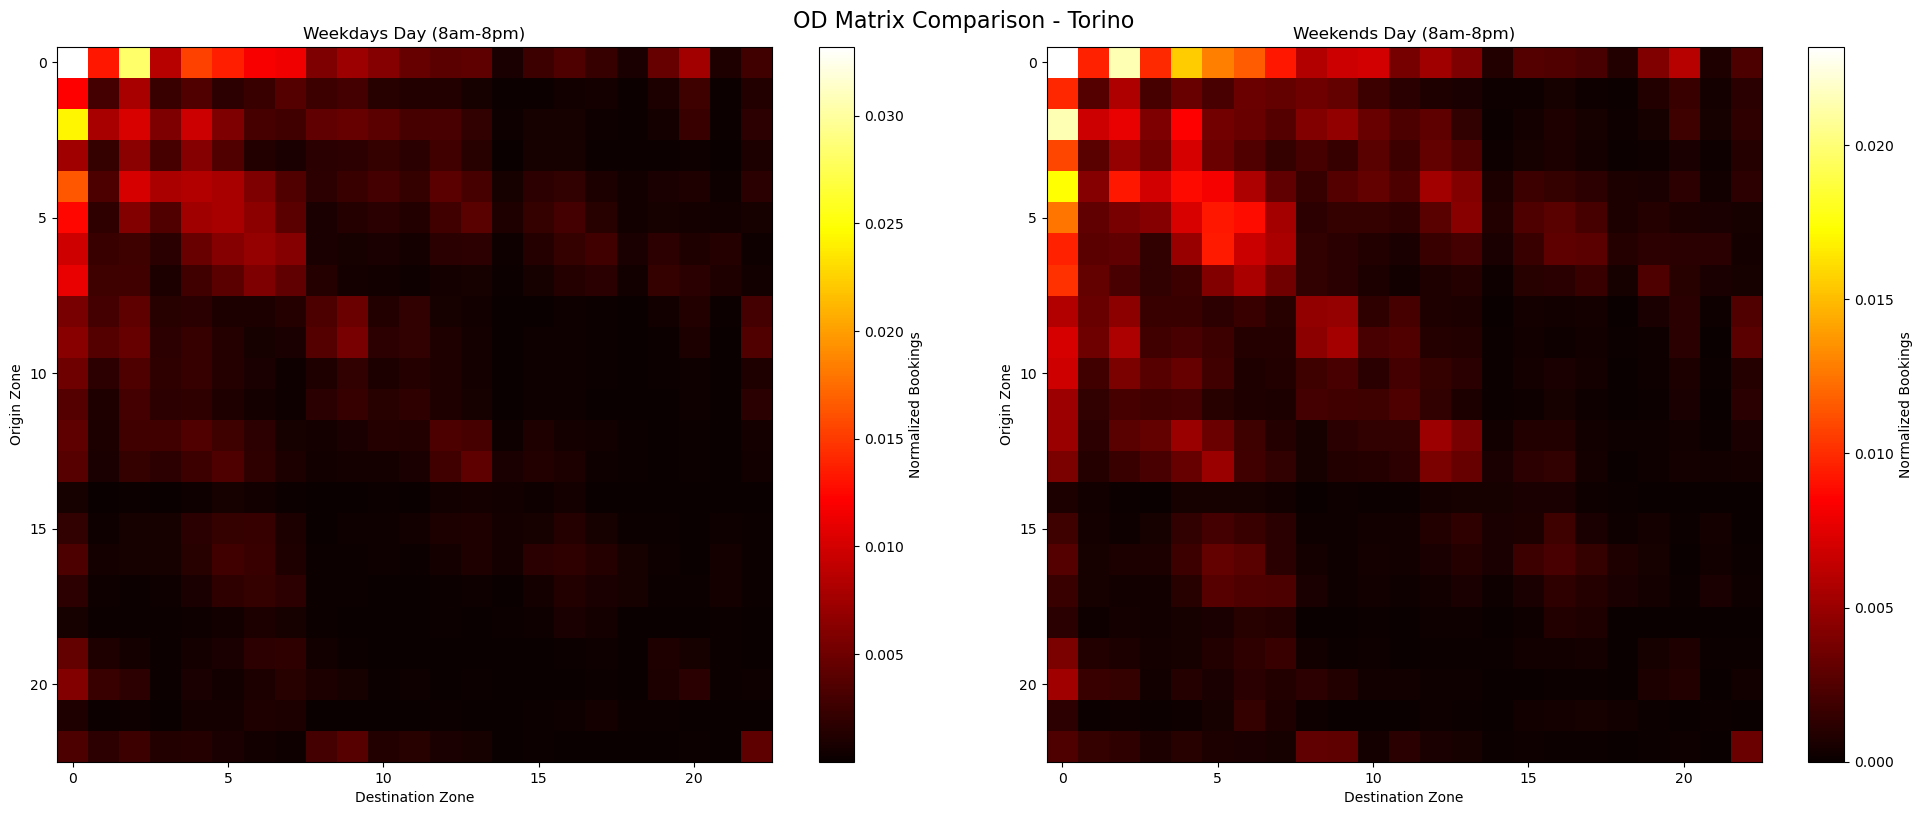

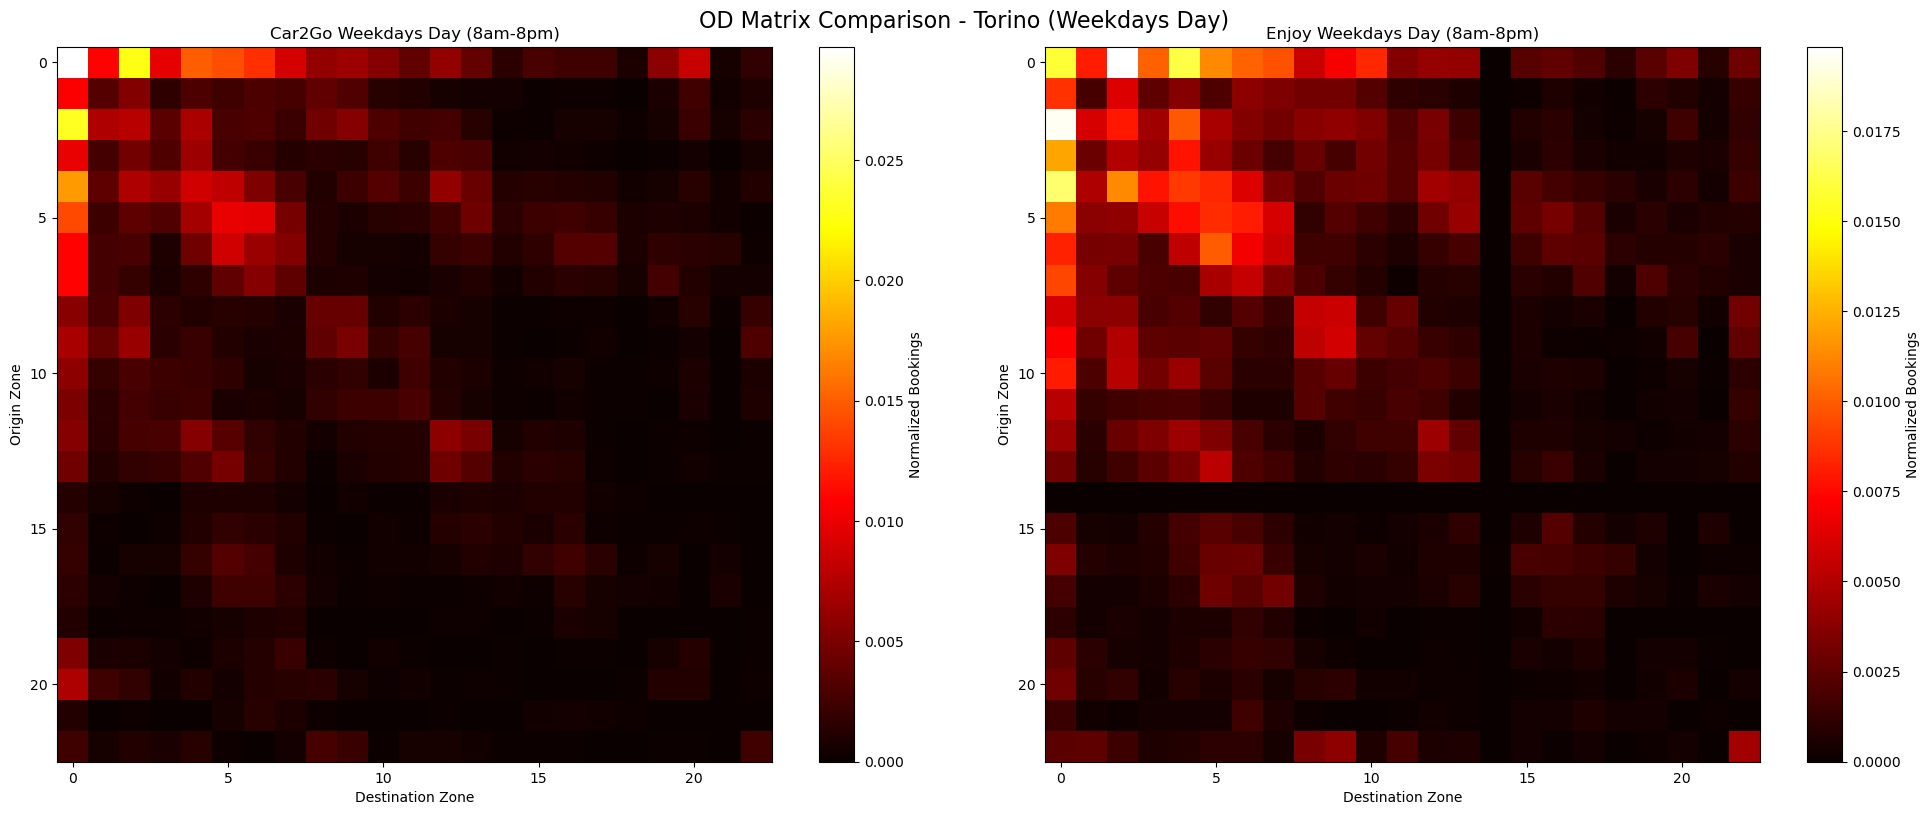

In [19]:
# plot all heatmaps
# comparison between weekday and weekend day
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle(f'OD Matrix Comparison - {city}', fontsize=16)

titles = {
    'weekday_day': 'Weekdays Day (8am-8pm)',
    'weekend_day': 'Weekends Day (8am-8pm)',
}

positions = [0, 1]

for (period_name, ax_pos) in zip(['weekday_day', 'weekend_day'], positions):
    ax = axes[ax_pos]
    im = ax.imshow(OD_matrices[period_name], cmap='hot', interpolation='nearest')
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    ax.set_title(titles[period_name])
    plt.colorbar(im, ax=ax, label='Normalized Bookings')

plt.tight_layout()
plt.show()

# comparison between car2go and enjoy for weekday day
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle(f'OD Matrix Comparison - {city} (Weekdays Day)', fontsize=16)
titles = {
    'car2go : weekday_day': 'Car2Go Weekdays Day (8am-8pm)',
    'enjoy : weekday_day': 'Enjoy Weekdays Day (8am-8pm)',
}
positions = [0, 1]

for (period_name, ax_pos) in zip(['car2go : weekday_day', 'enjoy : weekday_day'], positions):
    ax = axes[ax_pos]
    if period_name == 'car2go : weekday_day':
        im = ax.imshow(car2go_OD_matrix, cmap='hot', interpolation='nearest')
    else:
        im = ax.imshow(enjoy_OD_matrix, cmap='hot', interpolation='nearest')
    ax.set_xlabel('Destination Zone')
    ax.set_ylabel('Origin Zone')
    ax.set_title(titles[period_name])
    plt.colorbar(im, ax=ax, label='Normalized Bookings')

plt.tight_layout()
plt.show()


**Derive metrics to compute similarity between the OD matrices**